## 寻找股价和roe之间的相关性
- 画图观察
- 回归模型？ 股价是否差分？
- 怎么找到pattern
- 策略回溯？

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
pricePath = "price59c.xlsx"  # 股价
roePath = "filteredROE.xlsx"  # 59个公司的ROE
diffPath = "diffROE59.xlsx"  # ROE的差分数据
price = pd.read_excel(pricePath, index_col=0)
roe = pd.read_excel(roePath)
diff = pd.read_excel(diffPath)

In [2]:
price.head()

,神州高铁000008.SZ,中集集团000039.SZ,中联重科000157.SZ,徐工机械000425.SZ,柳工000528.SZ,冰山冷热000530.SZ,创元科技000551.SZ,苏常柴A000570.SZ,哈工智能000584.SZ,山推股份000680.SZ,中核科技000777.SZ,冰轮环境000811.SZ,智慧农业000816.SZ,京山轻机000821.SZ,石化机械000852.SZ,冀东装备000856.SZ,航天科技000901.SZ,众合科技000925.SZ,华铁股份000976.SZ,精功科技002006.SZ,天奇股份002009.SZ,山东威达002026.SZ,巨轮智能002031.SZ,冰山B200530.SZ,苏常柴B200570.SZ,三一重工600031.SH,太原重工600169.SH,黄河旋风600172.SH,全柴动力600218.SH,北方股份600262.SH,标准股份600302.SH,振华重工600320.SH,汉马科技600375.SH,龙净环保600388.SH,国机通用600444.SH,双良节能600481.SH,晋西车轴600495.SH,科达制造600499.SH,航天晨光600501.SH,文一科技600520.SH,菲达环保600526.SH,中铁工业600528.SH,卓郎智能600545.SH,大西洋600558.SH,金自天正600560.SH,克劳斯600579.SH,天地科技600582.SH,龙溪股份600592.SH,安徽合力600761.SH,上海机电600835.SH,上柴股份600841.SH,上工申贝600843.SH,广日股份600894.SH,建设机械600984.SH,贵绳股份600992.SH,上柴B股900920.SH,上工B股900924.SH,机电B股900925.SH,振华B股900947.SH
日期,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-03-31,6.8169,1.7141,NaN,1.0030,0.9613,2.1426,6.1304,6.3989,2.8847,1.3026,2.7234,1.7791,2.7257,7.2796,2.4642,6.0652,3.5344,11.4967,NaN,NaN,NaN,NaN,NaN,0.4968,1.6637,NaN,1.1715,2.8038,7.3981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3584,4.9487,5.9088,6.8043,2.3801,NaN,NaN,0.0914,0.1255,0.1274,0.0227
2000-06-30,6.6332,2.7344,NaN,1.3443,1.1987,2.6916,5.3171,6.0259,3.9702,3.0431,3.5648,1.7435,2.5204,7.4876,2.7514,5.9560,3.4747,13.0060,7.6553,NaN,NaN,NaN,NaN,0.5866,1.6756,NaN,1.2277,2.7503,8.0173,9.8908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6737,4.9106,5.8948,6.9603,2.6776,NaN,NaN,0.1208,0.1724,0.1532,0.0301
2000-09-29,5.0766,2.2704,NaN,1.3480,1.3141,2.4075,4.5199,6.4132,4.7754,3.1549,3.9954,1.8289,2.3738,7.7775,2.7824,5.3805,3.1473,11.8388,9.0973,NaN,NaN,NaN,NaN,0.5396,1.5805,NaN,1.2810,2.5726,7.0498,9.9241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6054,4.7693,5.7915,7.1729,3.8375,NaN,NaN,0.1364,0.2026,0.1497,0.0319
2000-12-29,4.7376,2.5609,0.3387,1.6333,1.3860,3.0181,4.9933,6.2937,4.0056,2.6120,4.1050,2.1228,2.4937,8.9435,3.2104,6.5719,4.1436,14.7268,7.7788,NaN,NaN,NaN,NaN,0.7084,1.9013,NaN,1.4152,2.7374,7.9270,10.9232,6.9905,1.0323,NaN,2.6677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0401,5.8953,6.8016,8.3448,4.2582,NaN,NaN,0.1968,0.3448,0.2146,0.0504
2001-03-30,2.4107,2.8469,0.3196,1.6032,1.3442,2.7422,4.9407,6.2602,4.0881,2.3382,3.9373,1.9897,2.6958,9.2649,3.4545,6.8025,3.7401,12.3857,7.3524,NaN,NaN,NaN,NaN,1.6630,4.0641,NaN,1.4276,2.8374,7.7399,11.1630,8.1982,1.0727,NaN,2.4027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5062,NaN,NaN,NaN,NaN,1.9551,5.8482,6.6221,8.4960,4.8635,NaN,NaN,0.3220,0.6298,0.3871,0.0828


In [3]:
roe.head()

,code,name,2000-03,2000-06,2000-09,2000-12,2001-03,2001-06,2001-09,2001-12,2002-03,2002-06,2002-09,2002-12,2003-03,2003-06,2003-09,2003-12,2004-03,2004-06,2004-09,2004-12,2005-03,2005-06,2005-09,2005-12,2006-03,2006-06,2006-09,2006-12,2007-03,2007-06,2007-09,2007-12,2008-03,2008-06,2008-09,2008-12,2009-03,2009-06,...,2011-03,2011-06,2011-09,2011-12,2012-03,2012-06,2012-09,2012-12,2013-03,2013-06,2013-09,2013-12,2014-03,2014-06,2014-09,2014-12,2015-03,2015-06,2015-09,2015-12,2016-03,2016-06,2016-09,2016-12,2017-03,2017-06,2017-09,2017-12,2018-03,2018-06,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09,2020-12
0,000008.SZ,神州高铁,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.6037,0.4420,0.5155,1.4067,72.7001,0.6647,-0.2813,-4.1963,-3.6895,-0.1419,-0.4943,-0.2336,-1.5687,1.3578,0.1195,1.4102,-0.6607,0.3513,-0.0201,0.1004,0.5886,-0.1738,-0.2702,...,-0.3693,-0.0929,-0.1325,-0.1343,-0.0390,0.1108,0.0448,12.7015,0.7276,1.2035,1.1683,1.0225,0.8484,0.6718,0.1992,-0.3506,3.3732,0.4861,0.9219,3.1390,0.2726,0.5406,3.0597,5.1171,0.1525,0.7543,1.0669,11.2646,0.1479,0.7182,0.8794,2.7954,0.1604,0.7463,1.1356,3.9001,-1.4616,-2.5378,0.7020,NaN
1,000039.SZ,中集集团,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5906,3.1579,6.6820,4.7204,3.1600,3.5896,7.5109,7.1189,2.5685,3.4281,13.0548,13.2110,8.4815,11.5342,13.0620,6.4893,0.2067,5.2731,8.8158,7.7845,5.5187,4.6459,5.6712,4.3983,8.3024,2.5148,4.0276,4.6980,-2.1224,3.0990,3.0499,...,8.0151,8.0941,2.8016,1.9884,1.9977,2.9896,3.4709,1.8387,1.1219,1.6964,2.1391,5.9002,0.6160,4.3392,2.7571,3.9016,2.2045,4.2590,0.8119,0.9188,1.4254,-2.7824,0.6789,2.5516,1.7225,0.9619,1.6961,3.8049,1.3646,1.6321,4.2918,3.0535,1.0623,0.7117,-0.1142,2.3391,-1.6447,1.1583,2.1542,NaN
2,000157.SZ,中联重科,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7083,2.0398,7.0492,2.8439,4.5008,2.6650,6.9962,5.1626,5.8195,8.3099,10.4170,5.8585,2.5054,4.5448,6.2432,4.6381,4.0505,4.1995,9.8241,6.1157,4.4947,8.7800,11.4498,13.0014,12.5128,9.5937,12.7137,10.4319,3.8510,5.7174,14.5901,...,6.9205,8.2447,4.0712,6.1112,5.7269,9.2298,3.3669,0.9111,1.4400,5.5425,2.1244,0.1059,0.9463,1.2088,0.2420,-0.9876,-0.9443,0.1827,-0.5236,1.5156,-1.6668,-0.4597,0.0916,-0.3543,0.2293,2.8255,0.4049,0.1324,0.9961,1.2990,1.1780,1.8944,2.5903,4.1326,2.4141,2.3247,2.6003,7.0930,3.6814,NaN
3,000425.SZ,徐工机械,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2559,3.2474,2.7717,3.1182,1.0807,5.0183,1.8569,2.2884,1.0372,3.8475,-1.0575,-0.8143,-3.0062,-4.8892,0.9743,-4.3397,0.3826,-0.2005,-0.0150,0.3367,0.1023,1.6356,0.6135,-0.2300,-1.1456,1.2555,8.9521,0.1548,-0.6870,1.7410,...,8.2041,9.0420,4.2144,3.6812,4.7752,5.2913,2.3012,2.9319,2.5385,2.1738,1.1155,2.3837,2.1058,1.8073,0.3490,-2.1262,-1.9235,1.9113,0.0202,0.1828,0.0513,0.5692,0.1883,0.2116,0.9815,1.6763,1.0171,1.0148,2.1403,2.3709,1.5403,1.8615,3.4380,3.9074,2.2892,1.8277,1.8240,4.2272,1.1084,NaN
4,000528.SZ,柳工,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6334,3.7158,5.0962,5.9681,6.7560,7.7067,6.9201,4.0173,10.2589,6.4555,1.3485,2.0366,3.9106,4.4039,2.2727,2.8437,4.5591,7.4501,4.4143,4.3900,5.4017,10.7015,6.0199,4.8946,5.8162,8.8764,0.8156,-1.8405,5.5769,6.8266,...,6.9824,5.2252,1.5214,1.0540,1.5700,1.7308,0.2248,-0.5647,0.9883,1.8161,0.2319,0.5648,1.3323,0.3734,0.2088,0.2088,0.8045,0.1472,-0.7186,-0.0134,0.1682,0.0111,-0.1098,0.4862,1.2161,1.4998,0.3985,0.4764,3.1439,3.2659,1.2561,0.7812,3.1375,3.6226,2.2035,1.3220,1.6257,4.7731,2.8909,NaN


In [7]:
diff.head()

,code,name,2000-03,2000-06,2000-09,2000-12,2001-03,2001-06,2001-09,2001-12,2002-03,2002-06,2002-09,2002-12,2003-03,2003-06,2003-09,2003-12,2004-03,2004-06,2004-09,2004-12,2005-03,2005-06,2005-09,2005-12,2006-03,2006-06,2006-09,2006-12,2007-03,2007-06,2007-09,2007-12,2008-03,2008-06,2008-09,2008-12,2009-03,2009-06,...,2011-03,2011-06,2011-09,2011-12,2012-03,2012-06,2012-09,2012-12,2013-03,2013-06,2013-09,2013-12,2014-03,2014-06,2014-09,2014-12,2015-03,2015-06,2015-09,2015-12,2016-03,2016-06,2016-09,2016-12,2017-03,2017-06,2017-09,2017-12,2018-03,2018-06,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09,2020-12
0,000008.SZ,神州高铁,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0964,0.2227,-0.7968,-5.6030,-76.3896,-0.8066,-0.2130,3.9627,2.1208,1.4997,0.6138,1.6438,0.9080,-1.0065,-0.1396,-1.3098,1.2493,-0.5251,-0.2501,...,-0.2869,-0.1983,-0.2290,-1.2184,0.3303,0.2037,0.1773,12.8358,0.7666,1.0927,1.1235,-11.6790,0.1208,-0.5317,-0.9691,-1.3731,2.5248,-0.1857,0.7227,3.4896,-3.1006,0.0545,2.1378,1.9781,-0.1201,0.2137,-1.9928,6.1475,-0.0046,-0.0361,-0.1875,-8.4692,0.0125,0.0281,0.2562,1.1047,-1.6220,-3.2841,-0.4336,NaN
1,000039.SZ,中集集团,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5694,0.4317,0.8289,2.3985,-0.5915,-0.1615,5.5439,6.0921,5.9130,8.1061,0.0072,-6.7217,-8.2748,-6.2611,-4.2462,1.2952,5.3120,-0.6272,-3.1446,-3.3862,2.7837,-2.1311,-1.6436,0.2997,-10.4248,0.5842,-0.9777,...,5.5497,4.2337,-6.6049,-2.2576,-6.0174,-5.1045,0.6693,-0.1497,-0.8758,-1.2932,-1.3318,4.0615,-0.5059,2.6428,0.6180,-1.9986,1.5885,-0.0802,-1.9452,-2.9828,-0.7791,-7.0414,-0.1330,1.6328,0.2971,3.7443,1.0172,1.2533,-0.3579,0.6702,2.5957,-0.7514,-0.3023,-0.9204,-4.4060,-0.7144,-2.7070,0.4466,2.2684,NaN
2,000157.SZ,中联重科,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7925,0.6252,-0.0530,2.3187,1.3187,5.6449,3.4208,0.6959,-3.3141,-3.7651,-4.1738,-1.2204,1.5451,-0.3453,3.5809,1.4776,0.4442,4.5805,1.6257,6.8857,8.0181,0.8137,1.2639,-2.5695,-8.6618,-3.8763,1.8764,...,-0.1004,-2.2730,-2.1642,-1.1149,-1.1936,0.9851,-0.7043,-5.2001,-4.2869,-3.6873,-1.2425,-0.8052,-0.4937,-4.3337,-1.8824,-1.0935,-1.8906,-1.0261,-0.7656,2.5032,-0.7225,-0.6424,0.6152,-1.8699,1.8961,3.2852,0.3133,0.4867,0.7668,-1.5265,0.7731,1.7620,1.5942,2.8336,1.2361,0.4303,0.0100,2.9604,1.2673,NaN
3,000425.SZ,徐工机械,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1752,1.7709,-0.9148,-0.8298,-0.0435,-1.1708,-2.9144,-3.1027,-4.0434,-8.7367,2.0318,-3.5254,3.3888,4.6887,-0.9893,4.6764,-0.2803,1.8361,0.6285,-0.5667,-1.2479,-0.3801,8.3386,0.3848,0.4586,0.4855,...,-2.7185,-7.7298,-2.9501,-4.4915,-3.4289,-3.7507,-1.9132,-0.7493,-2.2367,-3.1175,-1.1857,-0.5482,-0.4327,-0.3665,-0.7665,-4.5099,-4.0293,0.1040,-0.3288,2.3090,1.9748,-1.3421,0.1681,0.0288,0.9302,1.1071,0.8288,0.8032,1.1588,0.6946,0.5232,0.8467,1.2977,1.5365,0.7489,-0.0338,-1.6140,0.3198,-1.1808,NaN
4,000528.SZ,柳工,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.1226,3.9909,1.8239,-1.9508,3.5029,-1.2512,-5.5716,-1.9807,-6.3483,-2.0516,0.9242,0.8071,0.6485,3.0462,2.1416,1.5463,0.8426,3.2514,1.6056,0.5046,0.4145,-1.8251,-5.2043,-6.7351,-0.2393,-2.0498,...,-2.0790,-6.1383,-5.3544,-3.1094,-5.4124,-3.4944,-1.2966,-1.6187,-0.5817,0.0853,0.0071,1.1295,0.3440,-1.4427,-0.0231,-0.3560,-0.5278,-0.2262,-0.9274,-0.2222,-0.6363,-0.1361,0.6088,0.4996,1.0479,1.4887,0.5083,-0.0098,1.9278,1.7661,0.8576,0.3048,-0.0064,0.3567,0.9474,0.5408,-1.5118,1.1505,0.6874,NaN


In [22]:
def drawPrice(companyCode, companyName, roeData, priceData, n=8, gaussian=False):
    '''
    Description: 绘制股价走势，平滑曲线，roe变化
    ---
    Params:一列数据
    ---
    Returns:
    '''
    company = roeData[roeData["code"] == companyCode]
    x = [datetime.strptime(d, '%Y-%m').date() for d in company.columns[2:]]
    yROE = company.iloc[0,2:]
    if gaussian:
        yRolling = yROE.rolling(n, win_type="gaussian").mean(std=np.std(yROE, ddof=1))
    else:
        yRolling = yROE.rolling(n).mean()
    fig, axs = plt.subplots(figsize=(12, 5))
    # ROE 和平滑曲线
    axs.plot(x, yROE, label="ROE")
    axs.plot(x, yRolling, label="roll ROE")
    # 股价走势
    priceLabel = companyName+companyCode
    price = priceData[priceLabel]
    axs.plot(x, price.values, label="price")
    fig.legend()
    print(companyCode, companyName)

In [8]:
from random import randint

In [18]:
def pickOne():
    one = randint(0, 58)
    companyCode = roe.iloc[one, 0]
    companyName = roe.iloc[one, 1]
    return companyCode, companyName

600031.SH 三一重工


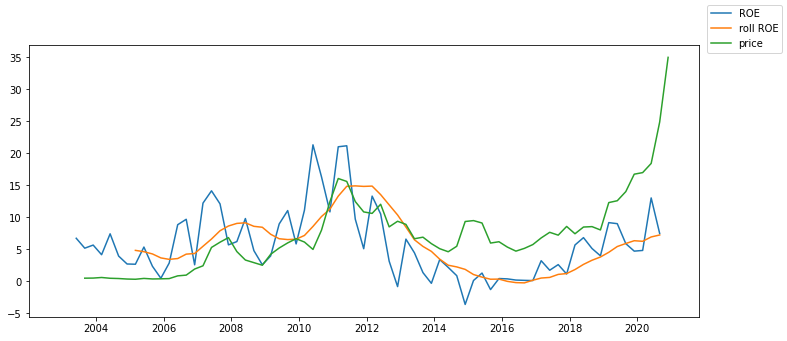

In [135]:
drawPrice(*pickOne(), roe, price, gaussian=True)

## 回归

In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [36]:
code, name = pickOne()
print(code, name)

600894.SH 广日股份


In [153]:
def concatOne(code, name, roe, price, rolling=True):
    # 将一个公司的roe和price结合成一个df
    tempROE = roe[roe["code"]==code].iloc[0, 2:]
    if rolling:
        tempROE = tempROE.rolling(8, win_type="gaussian").mean(std=np.std(tempROE, ddof=1))
    tempROE.name="roe"
    tempPrice = price[name+code]
    tempPrice.name = "price"
    tempIndex = pd.to_datetime(tempPrice.index).date
    tempROE.index = tempIndex
    tempPrice.index = tempIndex
    temp = pd.concat([tempROE, tempPrice], axis=1)
    # 清楚nan
    temp = temp[~(temp["roe"].isnull()|temp["price"].isnull())]
    return temp

In [154]:
code = "600031.SH"
name = "三一重工"
temp = concatOne(code, name, roe, price)

In [155]:
# 回归
model = ols("price ~ roe", data=temp).fit()

In [156]:
X = np.array(temp["roe"],dtype=float)

In [157]:
X = sm.add_constant(X)

In [158]:
y = np.array(temp["price"],dtype=float)

In [159]:
model = sm.OLS(y, X)

In [160]:
results = model.fit()

In [161]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     8.506
Date:                Fri, 15 Jan 2021   Prob (F-statistic):            0.00495
Time:                        09:19:29   Log-Likelihood:                -184.85
No. Observations:                  63   AIC:                             373.7
Df Residuals:                      61   BIC:                             378.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1190      1.002      5.108      0.000       3.115       7.123
x1             0.4106      0.141      2.917      0.005       0.129       0.692
==============================================================================
Omnibus:                       14.314   Durbin-Watson:                   0.143
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.261
Skew:                           0.954   Prob(JB):                     0.000179
Kurtosis:                       4.714   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""